## Exogenous data preparation
Alright, time to finally start adding some other features besides just microbusiness density. Have a few ideas to start with, they are as follows:

**DATA TODO:**
1. Add more features from original data, possibilities:
    - ~~Detrended microbusiness data~~
    - ~~Cyclical month~~
    - ~~Linear year~~
    - ~~Absolute number of microbusinesses~~ already present
    - ~~Population~~
2. ~~Add county location as lat, long features from CFIPS (geographical location may matter? i.e. nearness to large cities, part of the county etc.)~~
3. Add American Community Survey data from competition's census starter file
4. More?

<a name="load_inspect"></a>
### 1. Load & inspect

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
#import functions.data_manipulation_functions as data_funcs

import shelve
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
#import multiprocessing as mp
#from statistics import NormalDist

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')
print(f'Geopandas {gp.__version__}')

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3
Geopandas 0.12.2


In [2]:
# Load up training file, set dtype for first day of month
paths = conf.DataFilePaths()

training_df = pd.read_csv(f'{paths.KAGGLE_DATA_PATH}/updated_train.csv.zip', compression='zip')

# Convert timepoint to datetime
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

# Prune redundant columns, leaving county for now so that we can verify our county level
# merge with other datasets later
training_df.drop(['row_id', 'state'], axis=1, inplace=True)

# Inspect
training_df.head()

,cfips,county,first_day_of_month,microbusiness_density,active
0,1001,Autauga County,2019-08-01,3.007682,1249
1,1001,Autauga County,2019-09-01,2.884870,1198
2,1001,Autauga County,2019-10-01,3.055843,1269
3,1001,Autauga County,2019-11-01,2.993233,1243
4,1001,Autauga County,2019-12-01,2.993233,1243


<a name="difference"></a>
### 2. Microbusiness density change

In [3]:
# Let's also add a columns with difference detrended data (see notebook #02.2)

# Makes sure the rows are in chronological order within each county
training_df = training_df.sort_values(by=['cfips', 'first_day_of_month'])

# Calculate and add column for month to month change in MBD (first order difference)
training_df['microbusiness_density_change'] = training_df.groupby(['cfips'])['microbusiness_density'].diff() # type: ignore

# Calculate and add column for month to month change in MBD change (second order difference)
training_df['microbusiness_density_change_change'] = training_df.groupby(['cfips'])['microbusiness_density_change'].diff() # type: ignore

# Now the first two rows of each counties time series has a NAN, because there is no preceding timepoint to subtract
# for the second order difference. So just drop those rows resulting in a total timeseries size of 37
training_df.dropna(inplace=True)

# Inspect
training_df.head()

,cfips,county,first_day_of_month,microbusiness_density,active,microbusiness_density_change,microbusiness_density_change_change
2,1001,Autauga County,2019-10-01,3.055843,1269,0.170973,0.293785
3,1001,Autauga County,2019-11-01,2.993233,1243,-0.062610,-0.233583
4,1001,Autauga County,2019-12-01,2.993233,1243,0.000000,0.062610
5,1001,Autauga County,2020-01-01,2.969090,1242,-0.024143,-0.024143
6,1001,Autauga County,2020-02-01,2.909326,1217,-0.059764,-0.035621


<a name="month"></a>
### 3. Cyclical month
Pretty standard approach here - we will use two features: sine and cosine to capture the cyclical nature of the months of the year, rather than using one-hot encoding or categorical. 

In [4]:
# Get month as int
training_df['month'] = training_df['first_day_of_month'].dt.month

# Add sin month
training_df['sin_month'] = np.sin(training_df['month'])

# Add cos month
training_df['cos_month'] = np.cos(training_df['month'])

# Inspect
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122265 entries, 2 to 128534
Data columns (total 10 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   cfips                                122265 non-null  int64         
 1   county                               122265 non-null  object        
 2   first_day_of_month                   122265 non-null  datetime64[ns]
 3   microbusiness_density                122265 non-null  float64       
 4   active                               122265 non-null  int64         
 5   microbusiness_density_change         122265 non-null  float64       
 6   microbusiness_density_change_change  122265 non-null  float64       
 7   month                                122265 non-null  int64         
 8   sin_month                            122265 non-null  float64       
 9   cos_month                            122265 non-null  float64       
d

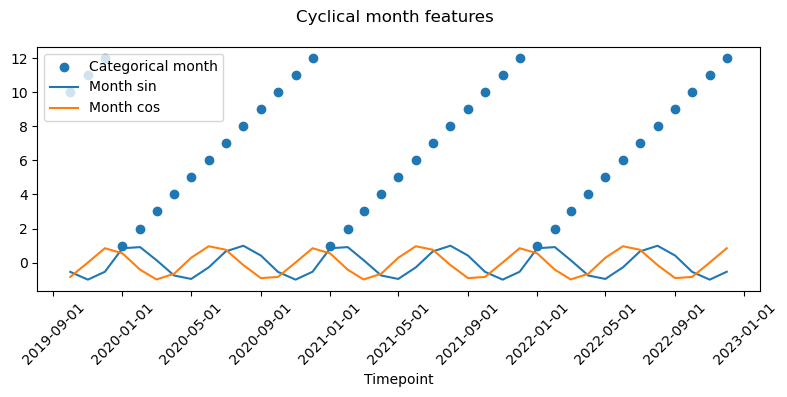

In [5]:
# Plot a random county to sanity check new features
timeseries_plot_data = training_df[training_df['cfips'] == 1001]

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.scatter(timeseries_plot_data['first_day_of_month'], timeseries_plot_data['month'], label='Categorical month')
ax.plot(timeseries_plot_data['first_day_of_month'], timeseries_plot_data['sin_month'], label='Month sin')
ax.plot(timeseries_plot_data['first_day_of_month'], timeseries_plot_data['cos_month'], label='Month cos')
ax.set_xlabel('Timepoint')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.suptitle('Cyclical month features')
plt.legend(loc='upper left')
plt.tight_layout()

<a name="year"></a>
### 4. Categorical year

In [6]:
# Get year as int
training_df['year'] = training_df['first_day_of_month'].dt.year

# Scale to make first year in dataset zero
training_df['year'] = training_df['year'] - min(training_df['year'])

# Inspect
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122265 entries, 2 to 128534
Data columns (total 11 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   cfips                                122265 non-null  int64         
 1   county                               122265 non-null  object        
 2   first_day_of_month                   122265 non-null  datetime64[ns]
 3   microbusiness_density                122265 non-null  float64       
 4   active                               122265 non-null  int64         
 5   microbusiness_density_change         122265 non-null  float64       
 6   microbusiness_density_change_change  122265 non-null  float64       
 7   month                                122265 non-null  int64         
 8   sin_month                            122265 non-null  float64       
 9   cos_month                            122265 non-null  float64       
 

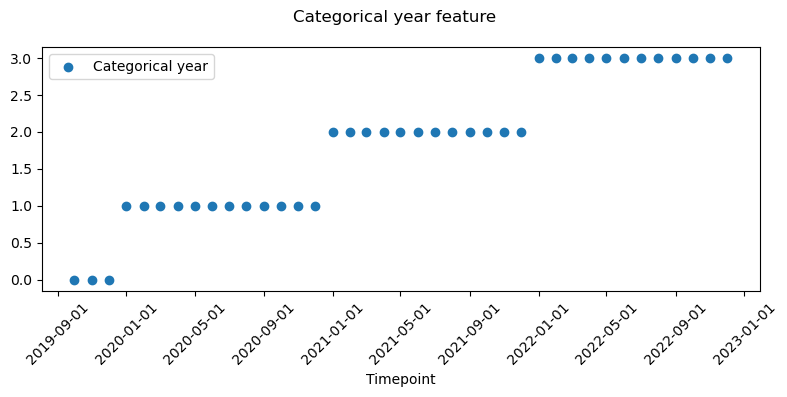

In [7]:
# Plot a random county to sanity check new features
timeseries_plot_data = training_df[training_df['cfips'] == 1001]

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.scatter(timeseries_plot_data['first_day_of_month'], timeseries_plot_data['year'], label='Categorical year')
ax.set_xlabel('Timepoint')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.suptitle('Categorical year feature')
plt.legend(loc='upper left')
plt.tight_layout()

<a name="population"></a>
### 4. Population
We can get population from the original data using the microbusiness density and the absolute number of microbusinesses. The MBD is defined as microbusinesses per 100 people.

In [8]:
# Calculate population
training_df['population'] = (training_df['active'] / training_df['microbusiness_density']) * 100

# Inspect
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122265 entries, 2 to 128534
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   cfips                                122265 non-null  int64         
 1   county                               122265 non-null  object        
 2   first_day_of_month                   122265 non-null  datetime64[ns]
 3   microbusiness_density                122265 non-null  float64       
 4   active                               122265 non-null  int64         
 5   microbusiness_density_change         122265 non-null  float64       
 6   microbusiness_density_change_change  122265 non-null  float64       
 7   month                                122265 non-null  int64         
 8   sin_month                            122265 non-null  float64       
 9   cos_month                            122265 non-null  float64       
 

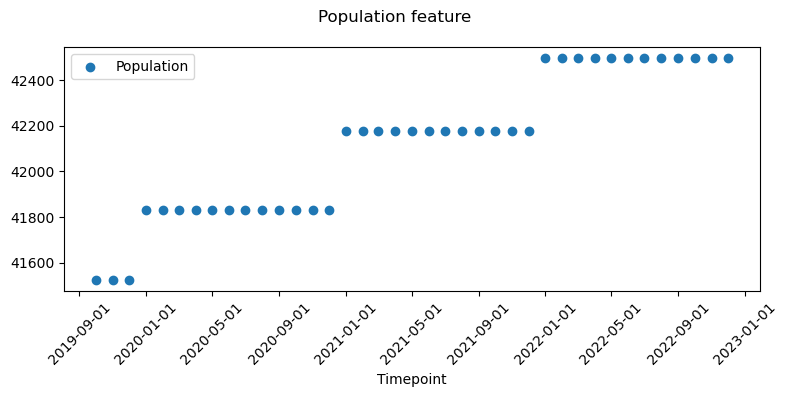

In [9]:
# Plot a random county to sanity check new features
timeseries_plot_data = training_df[training_df['cfips'] == 1001]

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.scatter(timeseries_plot_data['first_day_of_month'], timeseries_plot_data['population'], label='Population')
ax.set_xlabel('Timepoint')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.suptitle('Population feature')
plt.legend(loc='upper left')
plt.tight_layout()

<a name="location"></a>
### 5. County location

In [10]:
# Load data with geopandas, taking only the County layer and ignoring the geometry part of the file
geo_df = gp.read_file(
    f'{paths.CENSUS_DATA_PATH}/tlgdb_2022_a_us_substategeo.gdb', 
    ignore_geometry=True, 
    layer='County'
)

# Change county ID colname to match Kaggle data
geo_df.rename(columns={'GEOID': 'cfips'}, inplace=True)

# Inspect
geo_df.head()

,COUNTYNS,cfips,NAMELSAD,CLASSFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,00161526,01001,Autauga County,H1,A,1.539631e+09,2.567754e+07,+32.5322367,-86.6464395
1,00161527,01003,Baldwin County,H1,A,4.117725e+09,1.132887e+09,+30.6592183,-87.7460666
2,00161528,01005,Barbour County,H1,A,2.292160e+09,5.052321e+07,+31.8702531,-85.4051035
3,00161529,01007,Bibb County,H1,A,1.612189e+09,9.572302e+06,+33.0158929,-87.1271475
4,00161530,01009,Blount County,H1,A,1.670259e+09,1.486028e+07,+33.9773575,-86.5664400


OK, cool. Looks like we can get what we need from this. Just need to join on GEOID (CFIPS). Only wrinkle here is that in the census.gov data the leading state part of the CFIPS looks to be zero padded - e.g. 1001 becomes 01001 while 78030 is the same in both datasets. Let's see if we can fix that.

In [11]:
# Convert cfips to string and then left pad with '0' to 5 characters
training_df['cfips'] = training_df['cfips'].astype(str).str.pad(5, side='left', fillchar='0')

In [12]:
# Merge the two on CFIPS
training_df = pd.merge(training_df, geo_df, how='inner', on='cfips')
training_df.head()

,cfips,county,first_day_of_month,microbusiness_density,active,microbusiness_density_change,microbusiness_density_change_change,month,sin_month,cos_month,year,population,COUNTYNS,NAMELSAD,CLASSFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,01001,Autauga County,2019-10-01,3.055843,1269,0.170973,0.293785,10,-0.544021,-0.839072,0,41527.001174,00161526,Autauga County,H1,A,1.539631e+09,25677536.0,+32.5322367,-86.6464395
1,01001,Autauga County,2019-11-01,2.993233,1243,-0.062610,-0.233583,11,-0.999990,0.004426,0,41527.001638,00161526,Autauga County,H1,A,1.539631e+09,25677536.0,+32.5322367,-86.6464395
2,01001,Autauga County,2019-12-01,2.993233,1243,0.000000,0.062610,12,-0.536573,0.843854,0,41527.001638,00161526,Autauga County,H1,A,1.539631e+09,25677536.0,+32.5322367,-86.6464395
3,01001,Autauga County,2020-01-01,2.969090,1242,-0.024143,-0.024143,1,0.841471,0.540302,1,41830.998724,00161526,Autauga County,H1,A,1.539631e+09,25677536.0,+32.5322367,-86.6464395
4,01001,Autauga County,2020-02-01,2.909326,1217,-0.059764,-0.035621,2,0.909297,-0.416147,1,41831.000284,00161526,Autauga County,H1,A,1.539631e+09,25677536.0,+32.5322367,-86.6464395


OK, join looks good. Let's clean up a bit. Also going to add population density column since we got the county area for free in the last step.

In [13]:
# Drop unnecessary columns
training_df.drop(['county', 'month', 'COUNTYNS', 'NAMELSAD', 'CLASSFP', 'FUNCSTAT', 'AWATER'], axis=1, inplace=True)

# Set some dtypes
training_df['cfips'] = training_df['cfips'].astype(int)
training_df['ALAND'] = training_df['ALAND'].astype(float)
training_df['INTPTLAT'] = training_df['INTPTLAT'].astype(float)
training_df['INTPTLON'] = training_df['INTPTLON'].astype(float)

# Convert timepoint to datetime int because we are going to use numpy for the final data structure
training_df['first_day_of_month'] = pd.to_datetime(training_df['first_day_of_month']).astype(int)

# Rename the new columns
training_df.rename(columns={
    'ALAND': 'area',
    'INTPTLAT': 'lat',
    'INTPTLON': 'lon'
}, inplace=True)

# Clean up
training_df.reset_index(inplace=True, drop=True)

# Inspect
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121953 entries, 0 to 121952
Data columns (total 13 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   cfips                                121953 non-null  int64  
 1   first_day_of_month                   121953 non-null  int64  
 2   microbusiness_density                121953 non-null  float64
 3   active                               121953 non-null  int64  
 4   microbusiness_density_change         121953 non-null  float64
 5   microbusiness_density_change_change  121953 non-null  float64
 6   sin_month                            121953 non-null  float64
 7   cos_month                            121953 non-null  float64
 8   year                                 121953 non-null  int64  
 9   population                           121926 non-null  float64
 10  area                                 121953 non-null  float64
 11  lat          

In [14]:
training_df.head()

,cfips,first_day_of_month,microbusiness_density,active,microbusiness_density_change,microbusiness_density_change_change,sin_month,cos_month,year,population,area,lat,lon
0,1001,1569888000000000000,3.055843,1269,0.170973,0.293785,-0.544021,-0.839072,0,41527.001174,1.539631e+09,32.532237,-86.646439
1,1001,1572566400000000000,2.993233,1243,-0.062610,-0.233583,-0.999990,0.004426,0,41527.001638,1.539631e+09,32.532237,-86.646439
2,1001,1575158400000000000,2.993233,1243,0.000000,0.062610,-0.536573,0.843854,0,41527.001638,1.539631e+09,32.532237,-86.646439
3,1001,1577836800000000000,2.969090,1242,-0.024143,-0.024143,0.841471,0.540302,1,41830.998724,1.539631e+09,32.532237,-86.646439
4,1001,1580515200000000000,2.909326,1217,-0.059764,-0.035621,0.909297,-0.416147,1,41831.000284,1.539631e+09,32.532237,-86.646439


<a name="census_starter"></a>
### 6. Kaggle census data

In [15]:
census_df = pd.read_csv(f'{paths.KAGGLE_DATA_PATH}/census_starter.csv')
census_df.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [16]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non-null   float64
 3   pct_bb_2020            3141 non-null   float64
 4   pct_bb_2021            3141 non-null   float64
 5   cfips                  3142 non-null   int64  
 6   pct_college_2017       3142 non-null   float64
 7   pct_college_2018       3142 non-null   float64
 8   pct_college_2019       3142 non-null   float64
 9   pct_college_2020       3141 non-null   float64
 10  pct_college_2021       3141 non-null   float64
 11  pct_foreign_born_2017  3142 non-null   float64
 12  pct_foreign_born_2018  3142 non-null   float64
 13  pct_foreign_born_2019  3142 non-null   float64
 14  pct_foreign_born_2020  3141 non-null   float64
 15  pct_

OK, so we have some good stuff here - issue is that it's in wide format with respect to year while we need long. Also, we are working with data spanning 2019 through 2022, while the census starter data only goes to 2021. The competition description mentions that the census starter data has a two year lag to 'match what information was avaiable (sp) at the time a given microbusiness data update was published'. Best way I can interpret this is that when they are publishing a given year's microbusiness data, they are working with census data from two years prior - i.e. in the census starter data the column labeled 2021 actually contains 2019 data? Seems messy.

And we are out of time, need to build with what we have and hope for the best.

<a name="build_data_structure"></a>
### 1. Build data structure
First thing to do is build a data structure that will make resampling as easy as possible and persist it to disk. Then we will implement resampling. This way when experimenting with/training models, it will be easy to generate samples on they fly without having to rebuild the whole thing in memory each time.

The trick here is that in the first dimension we want the timepoints, then the counties, then the data columns. But, the 'timepoints' we want in the first dimension are really the forecast origins for a subset of the timecourse.

Maybe the best way to think about it is to forget the model order, forecast horizon and forecast origin location for now and just pick a data instance size. Then, when feeding the sample to a model we can break each block into input and forecast halves on the fly however we want. This will also solve the problem we had in notebook #07 where if model order != forecast horizon NumPy complains about ragged arrays.

Not sure if there maybe would be a speed advantage of sharding the data to multiple files here - i.e. each timepoint gets its own file and then worker processes can be assigned to sample from and train on the timepoints independently. It also might not be a bad idea to us h5py. Let's save that for a later optimization to minimize complexity out of the gate and not spend time prematurely optimizing something that ends up not being the right idea.

In [17]:
# Going to need a list of unique cfips IDs to retrieve the counties
cfips_list = training_df['cfips'].drop_duplicates(keep='first').to_list()
print(f'Num counties: {len(cfips_list)}')

# Get number of timepoints per county
num_timepoints = training_df['first_day_of_month'].nunique()
print(f'Num timepoints: {num_timepoints}')

# Start loop with three points - two for input and one for forecast
# this is the smallest possible block for any sort of model that
# does more than carry forward the last datapoint

# Updated: 2/28, now that the November and December data has been published
# and we are staring the end of the competition in the face, we need to start
# working with a forecast horizon of 5 - this will be the situation on the
# final public leaderboard. This means that for a minimum model order of
# 2, the smallest block size is now 2 - two input points and 5 target points
for block_size in range(7, num_timepoints + 1):

    timepoints = []

    for left_edge in range(0, (num_timepoints - block_size + 1)):

        # Holder for individual blocks
        blocks = []

        # Now we go through each county and get this block range
        for cfips in cfips_list:

            # Get data for just this county
            county_data = training_df[training_df['cfips'] == cfips]

            # Get rows for the block range
            county_data = county_data.iloc[left_edge:(left_edge + block_size)]

            # Convert block range rows to numpy and collect
            blocks.append(county_data)
        
        # Convert list of blocks to numpy and collect
        timepoints.append(np.array(blocks))

    # Convert final result to numpy
    timepoints = np.array(timepoints)
    print(f'Timepoints shape: {timepoints.shape}')

    # Write to disk
    output_file = f'{paths.DATA_PATH}/parsed_data/supplemented_updated_structured_bootstrap_blocksize{block_size}.npy'
    np.save(output_file, timepoints)

Num counties: 3127
Num timepoints: 39


In [ ]:
# Build index for column names

with shelve.open(f'{paths.PARSED_DATA_PATH}/supplemented_updated_structured_bootstrap_column_index', 'c') as col_index:
    for i, col_name in enumerate(county_data.columns):
        col_index[col_name] = i

In [ ]:
# Print out some diagnostic info about the last set of timepoints
print(f'Timepoints shape: {timepoints.shape}') # type: ignore
print()
print('Column types:')

for column in timepoints[0,0,0,0:]: # type: ignore
    print(f'\t{type(column)}')

print()
print(f'Example block:\n{timepoints[0,0,0:,]}') # type: ignore

OK, looks good. We could use int for some of these columns, but we need float for the MBD, so let's leave it alone rather than using mixed types in a NumPy array. So, that's it - easy. Let's round trip it and try recovering some our values back into a nice pandas dataframe as a sanity check.

In [ ]:
# Check round-trip
loaded_timepoints = np.load(output_file)

# Inspect
print(f'Timepoints shape: {loaded_timepoints.shape}')
print(f'Example block:\n{loaded_timepoints[0,0,0:,]}')

OK, not surprisingly - we got the same thing back. Last thing to do before we call this done is to test if we can get our dates, row_ids and cfips back into a format that matches the original data.

In [ ]:
# Grab an example date column
test_dates = loaded_timepoints[0,0,0:,1] # type: ignore
print(f'Test dates: {test_dates}\ndtype: {type(test_dates)}\nelement dtype: {type(test_dates[0])}\n')

# Cast float64 to int64
test_dates = test_dates.astype(np.int64)
print(f'Test dates: {test_dates}\ndtype: {type(test_dates)}\nelement dtype: {type(test_dates[0])}\n')

# Convert to pandas dataframe with dtype datetime64[ns] and column name 'first_day_of_month'
test_dates_df = pd.DataFrame(pd.to_datetime(test_dates), columns=['first_day_of_month']).astype('datetime64')
test_dates_df.info()

In [ ]:
test_dates_df.head()

In [ ]:
# Grab an example cfips column
test_cfips = loaded_timepoints[0,0,0:,0] # type: ignore
print(f'Test cfips: {test_cfips}\ndtype: {type(test_cfips)}\nelement dtype: {type(test_cfips[0])}\n')

# Cast float64 to int64
test_cfips = test_cfips.astype(np.int64)
print(f'Test cfips: {test_cfips}\ndtype: {type(test_cfips)}\nelement dtype: {type(test_cfips[0])}\n')

# Convert to pandas dataframe with dtype int64 and column name 'cfips'
test_cfips_df = pd.DataFrame(test_cfips, columns=['cfips']).astype('int64')
test_cfips_df.info()

In [ ]:
test_cfips_df.head()

Ok, happy - making the rwo ID is just a string join from here, so no problem. An if for some reason we want the string county or state back, we can use a CFIPS lookup table. Time to move on.